# Neural Fields from Scratch

#### Step 1 : Understand and visulaize
Downloaded a tiny_nerf data file from http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [1]:
import numpy as np

def read_npz_file(file_path):
    """
    Function to read data from a .npz file.

    Parameters:
        file_path (str): Path to the .npz file.

    Returns:
        data (dict): A dictionary containing data stored in the .npz file.
    """
    data = np.load(file_path)
    return data

In [2]:
file_path = 'tiny_nerf_data.npz'
data = read_npz_file(file_path)
content = data.files
print("Content in the npz file : ",content)

Content in the npz file :  ['images', 'poses', 'focal']


In [3]:
for i in content :
    print(f"Shape of {i} : {data[i].shape} ")

Shape of images : (106, 100, 100, 3) 
Shape of poses : (106, 4, 4) 
Shape of focal : () 


The paper mentions the input as five-dimensional vector composed of the position of the camera and viewing angle (theta and phi). We have extracted both here out of the pose matrix

Position (X, Y, Z): [-1.3986591  3.5542498  1.2888215]
Theta (degrees): 71.35417507518699
Phi (degrees): 111.48050150790498


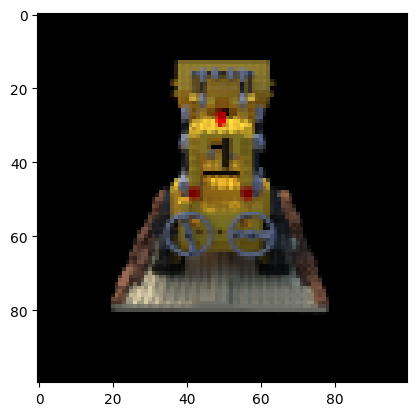

In [15]:
import matplotlib.pyplot as plt


images = data['images']
poses = data['poses']
focal = data['focal']


import numpy as np

import numpy as np

def extract_position_and_orientation(pose_matrix):
    # Extract the translation (position) from the pose matrix
    position = pose_matrix[:3, 3]

    # Extract the rotation (orientation) from the pose matrix
    rotation_matrix = pose_matrix[:3, :3]

    return position, rotation_matrix



position, rotation_matrix = extract_position_and_orientation(poses[1])

print("Position (X, Y, Z):", position)




def rotation_matrix_to_theta_phi(rotation_matrix):
    # Convert the rotation matrix to a direction vector
    direction_vector = rotation_matrix @ np.array([0, 0, 1])

    # Calculate theta (polar angle) and phi (azimuthal angle)
    theta = np.arccos(direction_vector[2])  # Polar angle (0 <= theta <= pi)
    phi = np.arctan2(direction_vector[1], direction_vector[0])  # Azimuthal angle (-pi <= phi < pi)

    # Convert angles from radians to degrees
    theta_degrees = np.degrees(theta)
    phi_degrees = np.degrees(phi)

    return theta_degrees, phi_degrees

theta, phi = rotation_matrix_to_theta_phi(rotation_matrix)

print("Theta (degrees):", theta)
print("Phi (degrees):", phi)



plt.imshow(images[0])
plt.show()



The dataset is visualised below

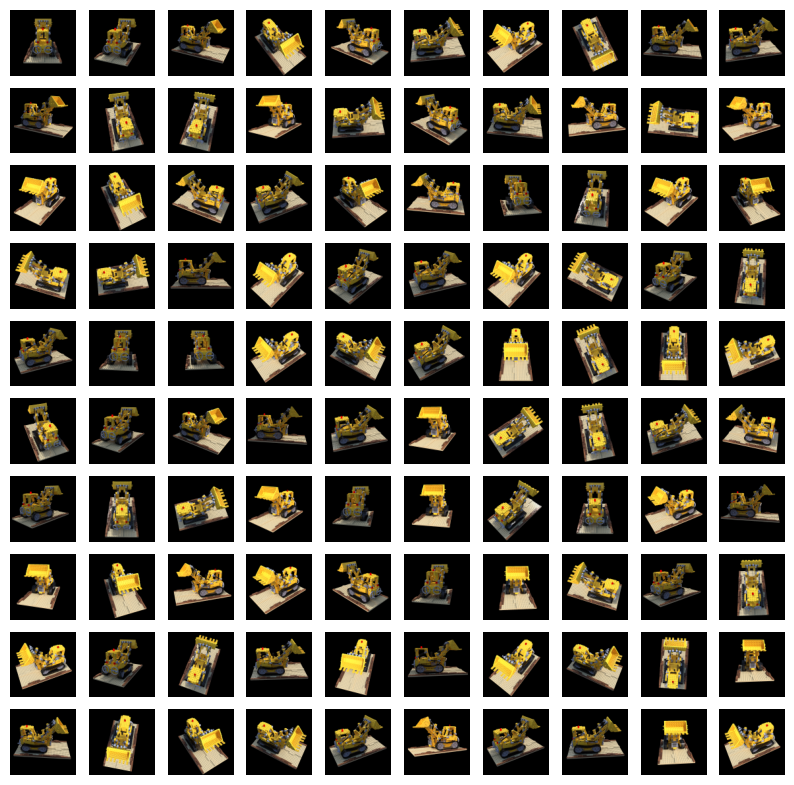

In [5]:
def plot_thumbnail_grid(image_list, grid_size=(10, 10), figsize=(10, 10)):

    num_images = len(image_list)
    rows, cols = grid_size

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.1)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(image_list[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()


plot_thumbnail_grid(images, grid_size=(10, 10))


The pose matrix is visualised below

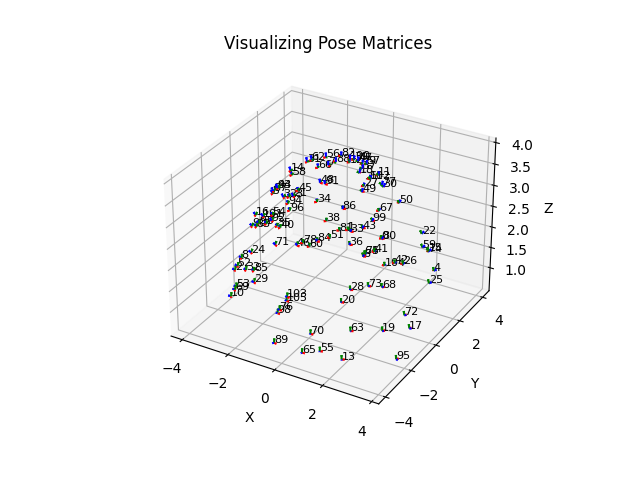

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

def visualize_poses(pose_matrices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for idx, pose_matrix in enumerate(pose_matrices):
        # Extract the translation and rotation components from the pose matrix
        translation = pose_matrix[:3, 3]
        rotation = pose_matrix[:3, :3]

        # X, Y, Z coordinates for the pose
        x = translation[0]
        y = translation[1]
        z = translation[2]

        # Plot the pose orientation vectors
        scale = 0.1  # Scaling factor for the orientation vectors
        ax.quiver(x, y, z, rotation[0, 0], rotation[1, 0], rotation[2, 0], length=scale, color='r')
        ax.quiver(x, y, z, rotation[0, 1], rotation[1, 1], rotation[2, 1], length=scale, color='g')
        ax.quiver(x, y, z, rotation[0, 2], rotation[1, 2], rotation[2, 2], length=scale, color='b')

        # Annotate the pose with its index
        ax.text(x, y, z, str(idx), color='black', fontsize=8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Visualizing Pose Matrices')

    plt.show()


visualize_poses(poses)


Accumulating all 5D co-ordinates into a singular array.

In [33]:
input_5D = []
for i in poses:
    position, rotation_matrix = extract_position_and_orientation(i)
    theta, phi = rotation_matrix_to_theta_phi(rotation_matrix)
    input_5D.append(np.array([position[0],position[1],position[2],theta,phi]))

input_5D = np.asarray(input_5D)
input_5D.shape

(106, 5)

In [37]:
import os
import imageio
import json
import torch
import cv2

trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w


def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1
        else:
            skip = testskip
            
        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame['transform_matrix']))
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    
    render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    
    if half_res:
        H = H//2
        W = W//2
        focal = focal/2.

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res
        # imgs = tf.image.resize_area(imgs, [400, 400]).numpy()

        
    return imgs, poses, render_poses, [H, W, focal], i_split

In [39]:
# For --config configs/lego.txt

datadir = "./data/nerf_synthetic/lego"
half_res = True
testskip = 8
images_new, poses_new, render_poses, hwf, i_split = load_blender_data(datadir,half_res,testskip)

print('Loaded blender', images.shape, render_poses.shape, hwf,datadir)
i_train, i_val, i_test = i_split

near = 2.
far = 6.
images_new= images_new[...,:3]*images[...,-1:] + (1.-images[...,-1:])


/var/folders/0_/jlz3w3sd0rvgpp49r0h93j_c0000gn/T/ipykernel_97855/3642122804.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))
